# 3. CKPlus VGG16 분류

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
import tensorflow as tf
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

import keras.backend.tensorflow_backend as K
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Add, Input, Conv2D, BatchNormalization, MaxPooling2D, GlobalMaxPooling2D, AveragePooling2D
from keras.optimizers import Adam, Adadelta
from keras.regularizers import l2
from keras.layers.advanced_activations import LeakyReLU
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint

from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image

Using TensorFlow backend.


## 3.1. 학습에 사용될 하이퍼 패러미터 선언 및 Random Seed 설정

In [2]:
np.random.seed(201)

In [3]:
CKPLUS_DIR = "datasets/CK+48/prep/"
INPUT_TRAIN_DATA = 'CKPlus_X.npy'
LABEL_TRAIN_DATA = 'CKPlus_y.npy'

TEST_SPLIT = 0.2
RND_SEED = 0

In [4]:
input_data = np.load(open(CKPLUS_DIR + INPUT_TRAIN_DATA, 'rb'))
label_data = np.load(open(CKPLUS_DIR+ LABEL_TRAIN_DATA, 'rb'))

In [5]:
input_data = np.squeeze(input_data)
input_data = np.stack((input_data,)*3, axis=3)

In [6]:
input_shape = input_data[1].shape
print('Input Shape is :', input_shape)

Input Shape is : (48, 48, 3)


In [7]:
x_train, x_test, y_train, y_test = train_test_split(input_data,
                                                    label_data,
                                                    test_size=TEST_SPLIT,
                                                    random_state=RND_SEED)

In [8]:
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  test_size=TEST_SPLIT,
                                                  random_state=RND_SEED)

In [9]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(185, 48, 48, 3)
(47, 48, 48, 3)
(59, 48, 48, 3)


## 3.2 CNN모델 정의

모델 컴파일

In [10]:
base_model = VGG16(weights=None, include_top=False, input_shape=(48, 48, 3))

In [11]:
x = base_model.output
x = Flatten()(x)
predictions = Dense(2, activation='softmax')(x)

In [12]:
model = Model(inputs=base_model.input, outputs=predictions)

In [13]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0   

모델 플롯 생성

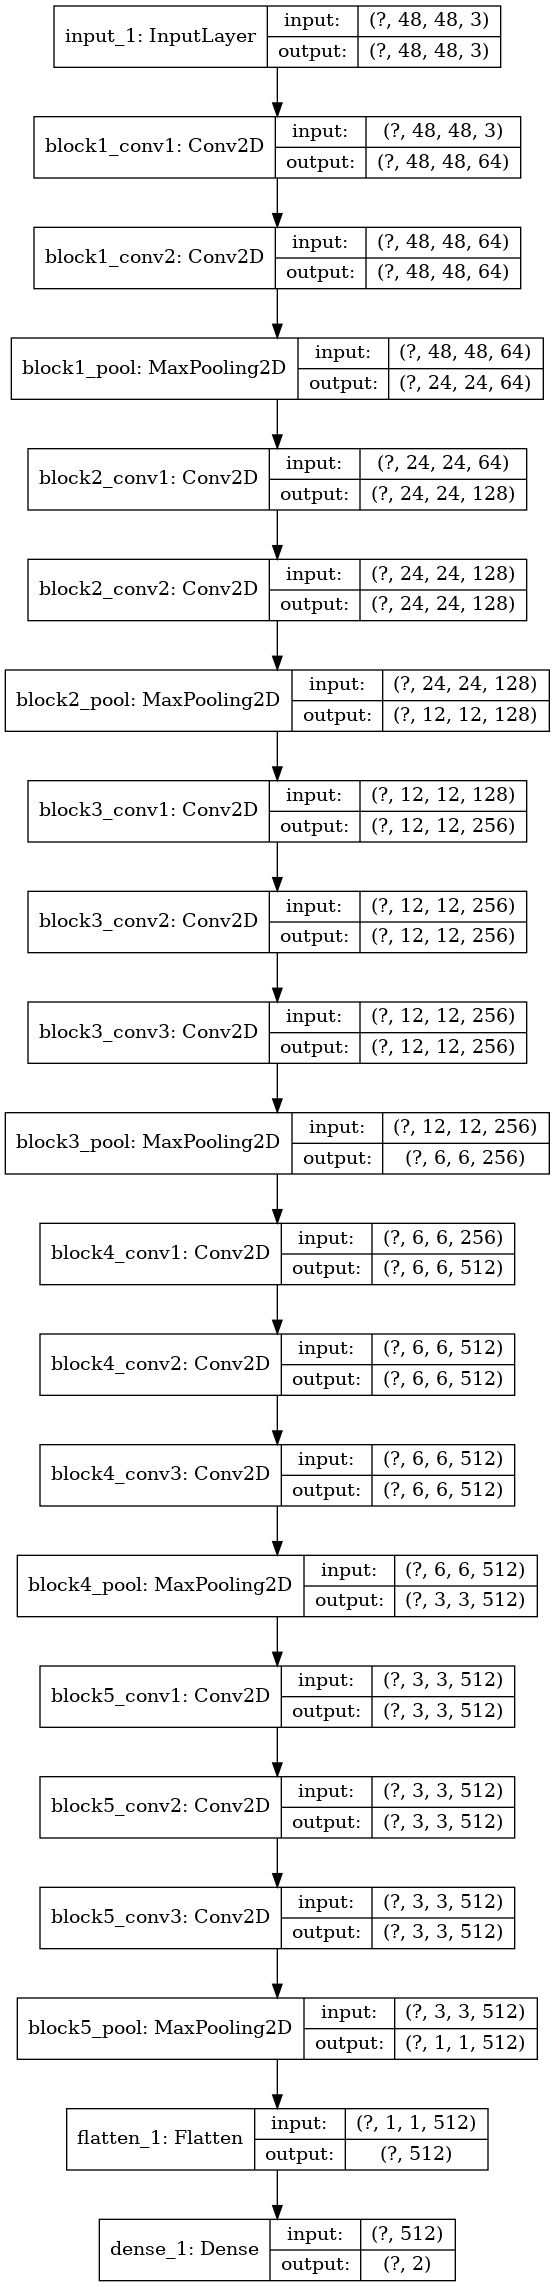

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [15]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [16]:
MODEL_PATH = 'weights.h5f'

In [17]:
check_point = ModelCheckpoint(filepath=MODEL_PATH, monitor='val_accuracy', verbose=1, save_best_only=True)

## 3.3 CNN 모델 훈련

In [18]:
batch_size = 32
epochs = 100

In [19]:
# Training
with K.tf_ops.device('/device:GPU:0'):
    history = model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size,
                        validation_data = (x_val, y_val), callbacks=[check_point])

Train on 185 samples, validate on 47 samples
Epoch 1/100
185/185 [==============================] - 2s 11ms/step - loss: 0.6655 - accuracy: 0.7514 - val_loss: 0.6350 - val_accuracy: 0.7021

Epoch 00001: val_accuracy improved from -inf to 0.70213, saving model to weights.h5f
Epoch 2/100
185/185 [==============================] - 0s 831us/step - loss: 0.7189 - accuracy: 0.7514 - val_loss: 0.6653 - val_accuracy: 0.7021

Epoch 00002: val_accuracy did not improve from 0.70213
Epoch 3/100
185/185 [==============================] - 0s 779us/step - loss: 0.6511 - accuracy: 0.7514 - val_loss: 0.6487 - val_accuracy: 0.7021

Epoch 00003: val_accuracy did not improve from 0.70213
Epoch 4/100
185/185 [==============================] - 0s 731us/step - loss: 0.6222 - accuracy: 0.7514 - val_loss: 0.6195 - val_accuracy: 0.7021

Epoch 00004: val_accuracy did not improve from 0.70213
Epoch 5/100
185/185 [==============================] - 0s 725us/step - loss: 0.5885 - accuracy: 0.7514 - val_loss: 0.6180 

185/185 [==============================] - 0s 733us/step - loss: 0.5622 - accuracy: 0.7514 - val_loss: 0.6145 - val_accuracy: 0.7021

Epoch 00041: val_accuracy did not improve from 0.70213
Epoch 42/100
185/185 [==============================] - 0s 731us/step - loss: 0.5622 - accuracy: 0.7514 - val_loss: 0.6136 - val_accuracy: 0.7021

Epoch 00042: val_accuracy did not improve from 0.70213
Epoch 43/100
185/185 [==============================] - 0s 732us/step - loss: 0.5614 - accuracy: 0.7514 - val_loss: 0.6167 - val_accuracy: 0.7021

Epoch 00043: val_accuracy did not improve from 0.70213
Epoch 44/100
185/185 [==============================] - 0s 733us/step - loss: 0.5613 - accuracy: 0.7514 - val_loss: 0.6166 - val_accuracy: 0.7021

Epoch 00044: val_accuracy did not improve from 0.70213
Epoch 45/100
185/185 [==============================] - 0s 736us/step - loss: 0.5623 - accuracy: 0.7514 - val_loss: 0.6193 - val_accuracy: 0.7021

Epoch 00045: val_accuracy did not improve from 0.70213
Epo


Epoch 00081: val_accuracy did not improve from 0.70213
Epoch 82/100
185/185 [==============================] - 0s 733us/step - loss: 0.5627 - accuracy: 0.7514 - val_loss: 0.6132 - val_accuracy: 0.7021

Epoch 00082: val_accuracy did not improve from 0.70213
Epoch 83/100
185/185 [==============================] - 0s 731us/step - loss: 0.5619 - accuracy: 0.7514 - val_loss: 0.6190 - val_accuracy: 0.7021

Epoch 00083: val_accuracy did not improve from 0.70213
Epoch 84/100
185/185 [==============================] - 0s 729us/step - loss: 0.5627 - accuracy: 0.7514 - val_loss: 0.6156 - val_accuracy: 0.7021

Epoch 00084: val_accuracy did not improve from 0.70213
Epoch 85/100
185/185 [==============================] - 0s 735us/step - loss: 0.5616 - accuracy: 0.7514 - val_loss: 0.6173 - val_accuracy: 0.7021

Epoch 00085: val_accuracy did not improve from 0.70213
Epoch 86/100
185/185 [==============================] - 0s 732us/step - loss: 0.5611 - accuracy: 0.7514 - val_loss: 0.6162 - val_accurac

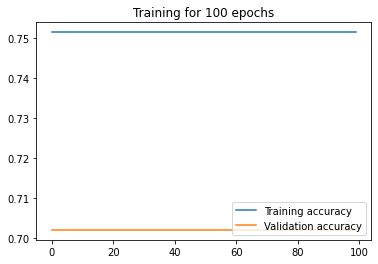

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training for ' +str(epochs)+ ' epochs')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.show()

검증셋 정확도

In [21]:
model.load_weights(MODEL_PATH)
results = model.evaluate(x_val, y_val)
print('Test accuracy: ', results[1])

47/47 [==============================] - 0s 248us/step
Test accuracy:  0.7021276354789734


테스트셋 정확도

In [22]:
results = model.evaluate(x_test, y_test)
print('Test accuracy: ', results[1])

59/59 [==============================] - 0s 3ms/step
Test accuracy:  0.5932203531265259


## 3.3 K-fold  Cross Validation 이용

In [23]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [24]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, random_state=RND_SEED, shuffle=True)

for train_index, test_index in kf.split(input_data):
    X_train, X_test = input_data[train_index], input_data[test_index]
    Y_train, Y_test = label_data[train_index], label_data[test_index]

In [25]:
with K.tf_ops.device('/device:GPU:0'):
    history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch_size,
                        validation_data = (X_test, Y_test), callbacks=[check_point])

Train on 262 samples, validate on 29 samples
Epoch 1/100
262/262 [==============================] - 1s 3ms/step - loss: 0.8407 - accuracy: 0.7137 - val_loss: 0.6717 - val_accuracy: 0.6897

Epoch 00001: val_accuracy did not improve from 0.70213
Epoch 2/100
262/262 [==============================] - 0s 715us/step - loss: 0.6983 - accuracy: 0.7137 - val_loss: 0.6409 - val_accuracy: 0.6897

Epoch 00002: val_accuracy did not improve from 0.70213
Epoch 3/100
262/262 [==============================] - 0s 715us/step - loss: 0.6278 - accuracy: 0.7137 - val_loss: 0.6253 - val_accuracy: 0.6897

Epoch 00003: val_accuracy did not improve from 0.70213
Epoch 4/100
262/262 [==============================] - 0s 716us/step - loss: 0.6118 - accuracy: 0.7137 - val_loss: 0.6285 - val_accuracy: 0.6897

Epoch 00004: val_accuracy did not improve from 0.70213
Epoch 5/100
262/262 [==============================] - 0s 717us/step - loss: 0.6030 - accuracy: 0.7137 - val_loss: 0.6197 - val_accuracy: 0.6897

Epoch 0

262/262 [==============================] - 0s 710us/step - loss: 0.3934 - accuracy: 0.9275 - val_loss: 0.0831 - val_accuracy: 0.9310

Epoch 00041: val_accuracy did not improve from 1.00000
Epoch 42/100
262/262 [==============================] - 0s 711us/step - loss: 0.0533 - accuracy: 0.9885 - val_loss: 0.0276 - val_accuracy: 1.0000

Epoch 00042: val_accuracy did not improve from 1.00000
Epoch 43/100
262/262 [==============================] - 0s 709us/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 2.4787e-06 - val_accuracy: 1.0000

Epoch 00043: val_accuracy did not improve from 1.00000
Epoch 44/100
262/262 [==============================] - 0s 714us/step - loss: 1.2421e-07 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

Epoch 00044: val_accuracy did not improve from 1.00000
Epoch 45/100
262/262 [==============================] - 0s 712us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

Epoch 00045: val_accuracy did not impr

262/262 [==============================] - 0s 713us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

Epoch 00080: val_accuracy did not improve from 1.00000
Epoch 81/100
262/262 [==============================] - 0s 718us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

Epoch 00081: val_accuracy did not improve from 1.00000
Epoch 82/100
262/262 [==============================] - 0s 715us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

Epoch 00082: val_accuracy did not improve from 1.00000
Epoch 83/100
262/262 [==============================] - 0s 716us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

Epoch 00083: val_accuracy did not improve from 1.00000
Epoch 84/100
262/262 [==============================] - 0s 716us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

Epoch 00084: val_a

테스트셋 정확도

In [26]:
results = model.evaluate(x_test, y_test)
print('Test accuracy: ', results[1])

59/59 [==============================] - 0s 971us/step
Test accuracy:  1.0
